In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_mmf_experiment import QDCMMFExperiment
from qdc.misc import tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, '..', 'data')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main results & dz dependence 

In [47]:
def run_mmf(is_step_index=False, only_z0=False):
    fiber_L = 0.1e6  if is_step_index else 3e6 # um 
    N_wl = 81
    N_classical = 23
    N_SPDC = 23
    wl0 = 0.810
    Dwl = 0.005 if is_step_index else 0.015
    NA_ref = 0.2   
    dzs = [0, 10, 50, 150, 400] if is_step_index else [0, 10, 30, 50, 250]
    if only_z0:
        dzs = [0]
    npoints = 2**8
    free_mode_matrix = False if npoints == 2**7 else True  # when working with 2**8, the RAM explodes 
    free_mode_matrix = True
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 

    
    n_pixels_diameter = npoints//4 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=123, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    
    if N_classical == 1:
        g_params_list = [np.array([0.7, 8, 0, 0.0, 0.0])]
    else:
        g_params_list = [np.array([0.6, Dx, 0, 0.0, 0.0]) for Dx in np.linspace(0, 22, N_classical)]
    
    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC, g_params_list=g_params_list)

    f_type = 'SI' if is_step_index else 'GRIN'
    if exp.excite_modes is not None:
        saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N={N_SPDC}_excite_modes={exp.excite_modes}.npz'
    else:
        saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N={N_SPDC}.npz'
    res.saveto(saveto_path)
    return res

res_SI = run_mmf(is_step_index=True, only_z0=False)
res_GRIN = run_mmf(is_step_index=False, only_z0=False)

Getting 81 fibers...


81it [00:01, 63.72it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements:   0%|          | 0/23 [00:00<?, ?it/s]C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\pyMMF\solvers\SI.py:147: RuntimeWarning: invalid value encountered in double_scalars
  return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))
C:\Users\owner\AppData\Roaming\Python\Python310\site-packages\pyMMF\solvers\SI.py:147: RuntimeWarning: invalid value encountered in divide
  return jv(m, u) / (u * jv(m - 1, u)) + kn(m, w) / (w * kn(m - 1, w))
Running classical measurements: 100%|██████████| 23/23 [1:06:07<00:00, 172.48s/it]


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:47:27<00:00, 280.35s/it]


Getting SPDC with average on 23, dz=10 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:47:18<00:00, 279.95s/it]


Getting SPDC with average on 23, dz=50 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:45:22<00:00, 274.91s/it]


Getting SPDC with average on 23, dz=150 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:45:47<00:00, 275.97s/it]


Getting SPDC with average on 23, dz=400 ...


Running SPDC measurements: 100%|██████████| 23/23 [1:44:47<00:00, 273.38s/it]


Getting 81 fibers...


81it [00:04, 19.63it/s]


Got fibers!
No modes found, not populating mega-beta matrix
Getting classical with average on 23 ...


Running classical measurements: 100%|██████████| 23/23 [25:18<00:00, 66.03s/it]  


Getting SPDC with average on 23, dz=0 ...


Running SPDC measurements: 100%|██████████| 23/23 [49:18<00:00, 128.65s/it]


Getting SPDC with average on 23, dz=10 ...


Running SPDC measurements: 100%|██████████| 23/23 [51:21<00:00, 133.97s/it]


Getting SPDC with average on 23, dz=30 ...


Running SPDC measurements: 100%|██████████| 23/23 [51:22<00:00, 134.03s/it]


Getting SPDC with average on 23, dz=50 ...


Running SPDC measurements: 100%|██████████| 23/23 [51:14<00:00, 133.69s/it]


Getting SPDC with average on 23, dz=250 ...


Running SPDC measurements: 100%|██████████| 23/23 [51:18<00:00, 133.85s/it]


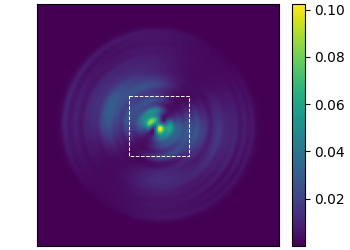

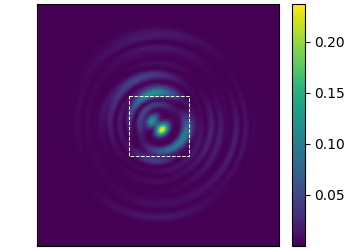

In [36]:
res_SI.show_incoherent_sums(iter_no=8, dz=0, saveto_path=None)

## View results 

fiber_type: SI


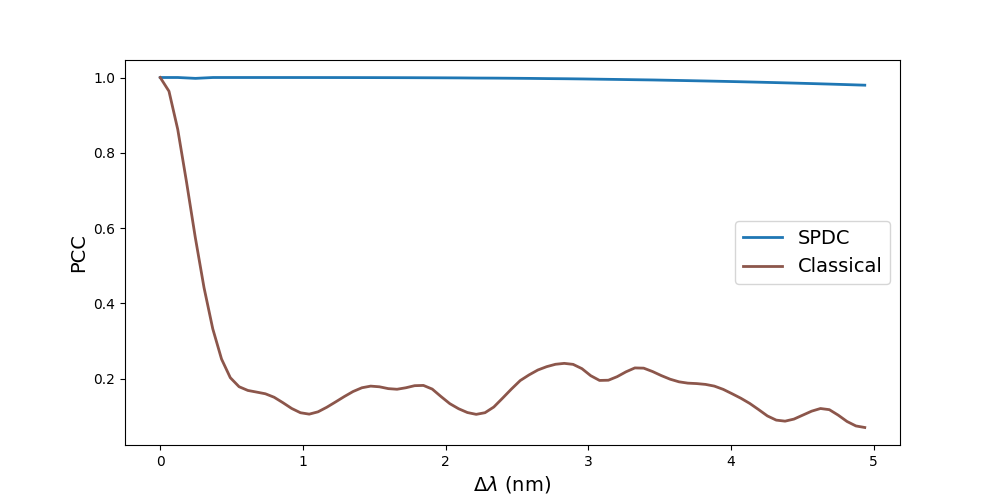

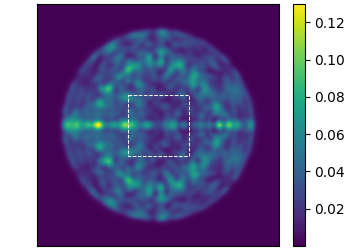

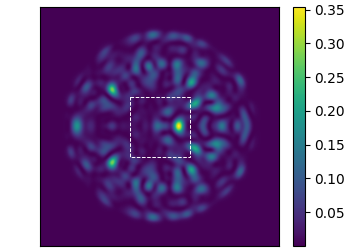

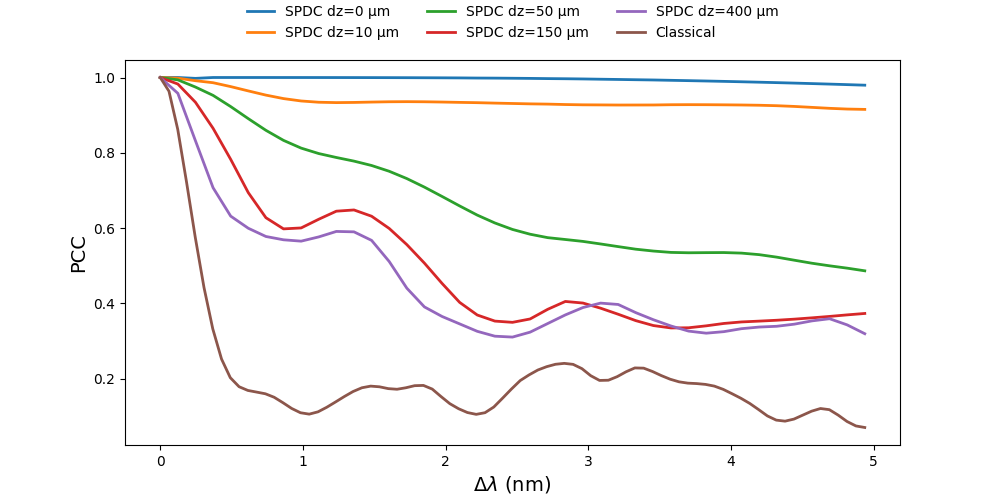

In [58]:
is_step_index = True
res = res_SI if is_step_index else res_GRIN
fiber_type = 'SI' if is_step_index else 'GRIN'

print(f'fiber_type: {fiber_type}')

# Main text 
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\PCCs_{fiber_type}.png'
# saveto_path = None
res.show_PCCs(title='', iter_no=None, show0=True, saveto_path=saveto_path)

saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Partial Figures\incoherent_sum_{fiber_type}.png'
# saveto_path = None
res.show_incoherent_sums(iter_no=16, dz=0, saveto_path=saveto_path)

# Combine these and the setup in pptx for final figure for main text 

# SI 
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_dzs_{fiber_type}.png'
# saveto_path = None
res.show_PCCs(title='', iter_no=None, show0=False, saveto_path=saveto_path)


In [ ]:
# res = res_GRIN
res = res_SI
for i in range(5):
    # res.show_incoherent_sum(iter_no=i, dz=0)
    res.show_PCCs(title='', iter_no=i, show0=False)
    print(res.metadata["g_params_list"][i])

# Phase matching dependence

In [ ]:
def run_phase_matching(is_step_index=False, Lc_um=2000, N_classical=10, N_SPDC=10):
    fiber_L = 0.2e6  if is_step_index else 3e6 # um 
    N_wl = 81
    wl0 = 0.810
    Dwl = 0.010 if is_step_index else 0.020
    NA_ref = 0.2   
    dzs = [0]
    npoints = 2**7
    free_mode_matrix = False if npoints == 2**7 else True  # when working with 2**8, the RAM explodes 
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 

    n_pixels_diameter = 2*npoints//5 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=42, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    s.gaussian_params = np.array([2.7, 7, 10, 0.5, 0.5]) 
    s.gaussian_dparams = np.array([1, 5, 5, 0.3, 0.3])
    # s.gaussian_dparams = np.array([0, 4, 4, 0.1, 0.1])
    
    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    exp.set_phase_matching(Lc_um=Lc_um, pump_waist_crystal=500, magnification=10)
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC)

    f_type = 'SI' if is_step_index else 'GRIN'
    saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N=100.npz'
    res.saveto(saveto_path)
    return res

N_classical = 5
N_SPDC = 5 
ress_SI = []
ress_GRIN = []

# Classical result does not depend on phase matching 
ress_SI.append(run_phase_matching(is_step_index=True, Lc_um=1000, N_classical=N_classical, N_SPDC=N_SPDC))
ress_GRIN.append(run_phase_matching(is_step_index=False, Lc_um=1000, N_classical=N_classical, N_SPDC=N_SPDC))

Lcs = [2000, 4000, 8000, 16000]
for Lc in Lcs:
    ress_SI.append(run_phase_matching(is_step_index=True, Lc_um=Lc, N_classical=1, N_SPDC=N_SPDC))
    ress_GRIN.append(run_phase_matching(is_step_index=False, Lc_um=Lc, N_classical=1, N_SPDC=N_SPDC))


## View results 

In [ ]:
def show_classical_and_spdc_phase_matching(results, L_cs, iter_no=None, saveto_path=None):
    fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

    # Plot SPDC from all results
    for i, res in enumerate(results):
        for dz_key, (dl, _) in res.SPDC_by_dz.items():
            if iter_no is None:
                y_spdc = res.SPDC_pccs_average(dz_key)
                label_spdc = f"SPDC Lc={L_cs[i]} μm"
            else:
                y_spdc = res.SPDC_pccs_all_by_dz[dz_key][iter_no]
                label_spdc = f"SPDC Lc={L_cs[i]} μm iter {iter_no}"
            ax.plot(dl * 1e3, y_spdc, '-', label=label_spdc, linewidth=2)

    res0 = results[0]
    if iter_no is None:
        y_classical = res0.classical_pccs_average
        label_classical = f"Classical"
    else:
        y_classical = res0.classical_pccs_all[iter_no]
        label_classical = f"Classical iter {iter_no}"
    ax.plot(res0.delta_lambdas_classical * 1e3, y_classical, '-', label=label_classical, linewidth=2, color='#8c564b')

    ax.set_xlabel(r"$\Delta \lambda$ (nm)", fontsize=14)
    ax.set_ylabel("PCC", fontsize=14)
    ax.legend(fontsize=12, loc='lower center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False)

    if saveto_path is not None:
        plt.savefig(saveto_path)
    else:
        plt.show()

Lcs = [1000, 2000, 4000, 8000, 16000]
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_Lcs_SI.png'
show_classical_and_spdc_phase_matching(ress_SI, Lcs, saveto_path=saveto_path)
saveto_path = fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\PCCs_Lcs_GRIN.png'
show_classical_and_spdc_phase_matching(ress_GRIN, Lcs, saveto_path=saveto_path)

# Effect of wavefront shaping on mode mixing 

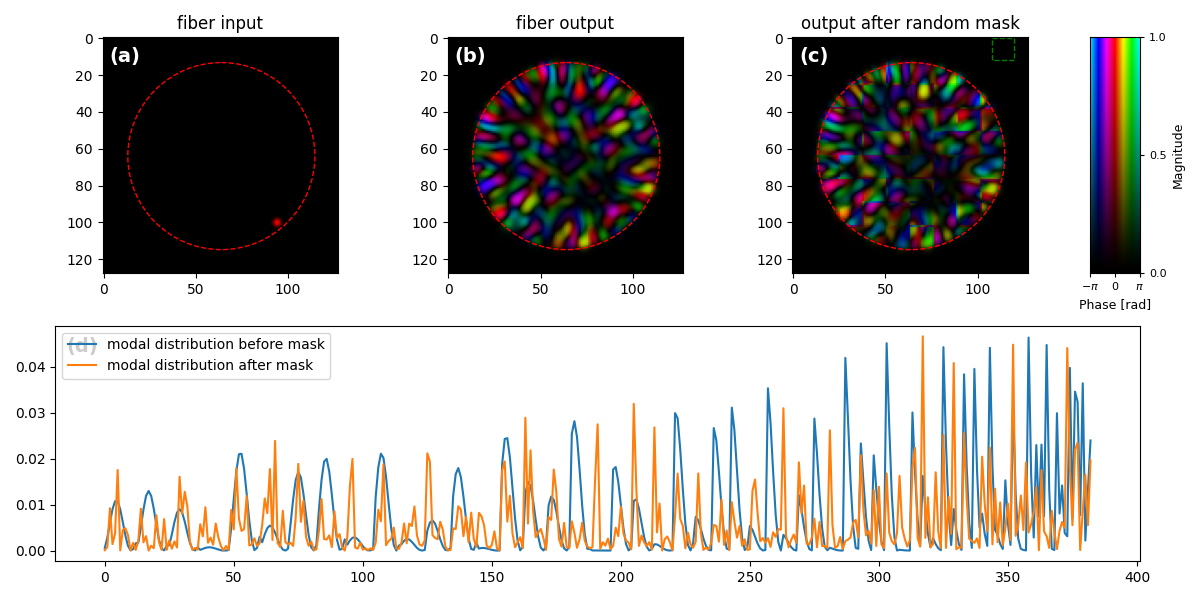

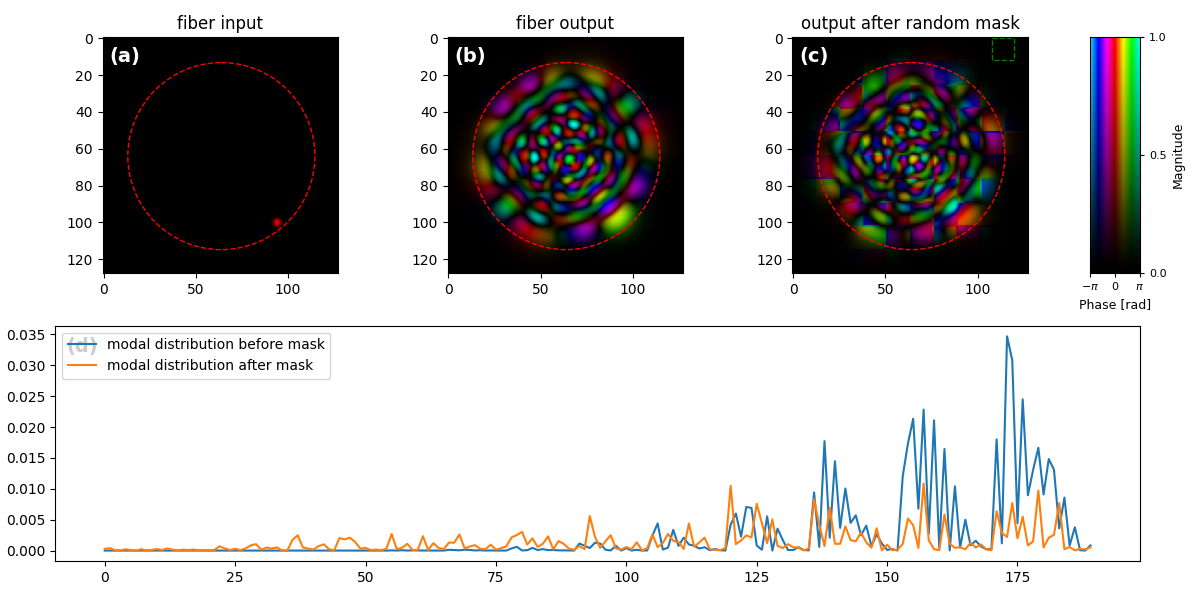

In [30]:
import cv2
from matplotlib import patches
from qdc.mmf.fiber import Fiber
from qdc.misc import show_color_legend_ax

def SLM_mixing(is_step_index, macro_pixels=10):
    f = Fiber(is_step_index=is_step_index, npoints=2**7)
    # f.set_input_gaussian(sigma=3, X0=5, Y0=10, X_linphase=0.4, Y_linphase=0.4, random_phase=0.0)
    f.set_input_gaussian(sigma=0.5, X0=15, Y0=18, X_linphase=0.0, Y_linphase=0.0, random_phase=0.0)
    f.propagate(False)

    fig, axes = plt.subplot_mosaic(
        [["left", "right", "masked", "legend"],
        ["bottom", "bottom", "bottom", "bottom"]],
        figsize=(12, 6),
        gridspec_kw={"width_ratios": [1, 1, 1, 0.15]}  
    )

    # Profile before fiber 
    f.show_profile(f.profile_0,   ax=axes["left"],   title='fiber input')
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["left"].add_patch(circle)
    
    # Profile before fiber 
    f.show_profile(f.profile_end, ax=axes["right"],  title='fiber output')
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["right"].add_patch(circle)

    # Profile after mask
    A = np.random.uniform(0, 2*np.pi, size=(macro_pixels, macro_pixels))
    if not isinstance(f.npoints, int):
        f.npoints = f.npoints.item()
    A = cv2.resize(A, (f.npoints, f.npoints), interpolation=cv2.INTER_AREA)
    A = np.exp(1j*A)
    profile_after_mask = f.profile_end * A.ravel()
    f.show_profile(profile_after_mask, ax=axes["masked"], title='output after random mask')
    square_size = f.npoints//macro_pixels
    square = patches.Rectangle((square_size*(macro_pixels-1),0), square_size, square_size, color='green', fill=False, linestyle='dashed')
    axes["masked"].add_patch(square)
    circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
    axes["masked"].add_patch(circle)

    # Legend 
    show_color_legend_ax(axes["legend"])

    # Modal distributions
    modes_after_mask = f.modes.getModeMatrix().T @ profile_after_mask
    axes["bottom"].plot(np.abs(f.modes_0)**2, label='modal distribution before mask')
    axes["bottom"].plot(np.abs(modes_after_mask)**2, label='modal distribution after mask')
    axes["bottom"].legend()

    # Panel labels
    axes["left"].text(0.03, 0.96, '(a)', color='white', fontsize=14, fontweight='bold', transform=axes["left"].transAxes, va='top', ha='left')
    axes["right"].text(0.03, 0.96, '(b)', color='white', fontsize=14, fontweight='bold', transform=axes["right"].transAxes, va='top', ha='left')
    axes["masked"].text(0.03, 0.96, '(c)', color='white', fontsize=14, fontweight='bold', transform=axes["masked"].transAxes, va='top', ha='left')
    axes["bottom"].text(0.01, 0.95, '(d)', color='black', fontsize=14, fontweight='bold', transform=axes["bottom"].transAxes, va='top', ha='left')

    plt.tight_layout()
    # Save figure 
    fiber_type = 'SI' if is_step_index else 'GRIN'
    fig.savefig(fr'G:\My Drive\Projects\Dispersion Cancelation\Paper\Final Figures\SLM_mixing_{fiber_type}.png')

macro_pixels = 10
SLM_mixing(is_step_index=True, macro_pixels=macro_pixels)
SLM_mixing(is_step_index=False, macro_pixels=macro_pixels)